<a href="https://colab.research.google.com/github/graviada/freelance/blob/main/AnotherTasks/R_Language/R_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Введение**

Проведем небольшое исследование с помощью возможностей языка R на тему анализа датасета пациентов, имеющих раковые заболевания. В их числе органы:
*   Грудная клетка (грудь)
*   Легкие
*   Кишечник
*   Яичники
*   Желудок

В данном наборе данные фактически сгруппированы по органам и учитывают такой показатель, как продолжительность жизни (вероятно, в днях). Далее мы подробнее рассмотрим датасет и сделаем некоторые выводы относительно одной из представленных групп пациентов.




## **Задание**

Пациентам, больным раком желудка, бронхов, кишечника, яичников или раком груди, давали в качестве поддерживающей терапии аскорбат (Cameron, Paulig, 1976, данные из кн.Hand et al. 1994).
Сравните время выживания пациентов (Survival) с раком груди и другими видами рака (с каждым в отдельности).

Исходные данные для анализа находятся в файле "cancer.xlsx".

In [ ]:
install.packages('caret')
install.packages('Hmisc')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("car"):
“installation of package ‘car’ had non-zero exit status”


In [ ]:
# Необходимые библиотеки
library(readxl)
library(ggplot2)
library(caret)
library(dplyr)
library(Hmisc)

### **1**
Кратко опишите исходные данные. Важно указать объемы выборок. 
Проверьте, нет ли пропущенных значений. Оцените, подходят ли данные для анализа при помощи t-критерия и какие могут быть ограничения и сложности.

  Визуализируйте характер распределения величины, находящейся в фокусе исследования (Среднее время выживания). Графики, визуализирующие распределения, должны быть включены в отчет.

  Поможет ли трансформация данных (например, извлечение квадратного корня из зависимой переменной) преодолеть хотя бы некоторые сложности анализа?

In [ ]:
cancer <- read_excel('cancer.xlsx')
str(cancer)

tibble [64 × 2] (S3: tbl_df/tbl/data.frame)
 $ Survival: num [1:64] 124 42 25 45 412 ...
 $ Organ   : chr [1:64] "Stomach" "Stomach" "Stomach" "Stomach" ...


Объем выборки: 64 объекта (строки) и 2 наблюдения (столбцы)

In [ ]:
head(cancer, n = 3)

Survival,Organ
<dbl>,<chr>
124,Stomach
42,Stomach
25,Stomach


In [ ]:
# Проверяем, нет ли пропущенных значений
colSums(is.na(cancer)) 

Survival    Organ 
       0        0

Пропущенных значений нет.

По условию, для больших выборок можно использовать t-интервал, если:

1. нет «выбросов»
2. умеренное отклонение от нормального распределения

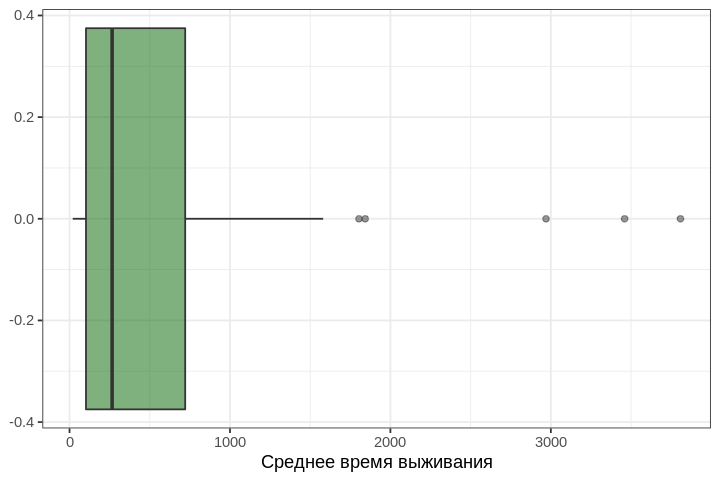

In [ ]:
# Для этого оцениваем распределение, используя ящик с усами
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(data = cancer, aes(x = Survival)) +
      geom_boxplot(fill = 'darkgreen', alpha = 0.5) +
      labs(x = 'Среднее время выживания') +
      theme_bw()

Выбросы присутсвуют. Отклонение посмотрим по графику распределения величины Survival.

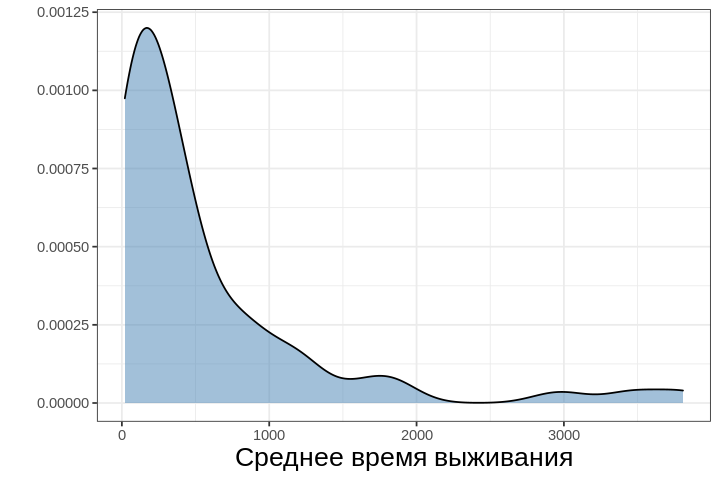

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(cancer, aes(x = Survival)) +
          geom_density(fill = 'steelblue', alpha = 0.5) +
          theme_bw() +
          theme(axis.title = element_text(size = 16)) +
          labs(x = 'Среднее время выживания', y = '')

Перед нами непрерывное распределение с длинным правым хвостом.

Сделаем стандартизацию данных и исключим выбросы. Это можно сделать при помощи квантилей.

In [ ]:
standardizedData <- as.numeric(scale(cancer$Survival))
standardizedData[1:6]

[1] -0.5597385 -0.6653435 -0.6872372 -0.6614799 -0.1888333 -0.6537527

In [ ]:
length(standardizedData)

[1] 64

In [ ]:
cancer$Standardized <- standardizedData
head(cancer, n = 3)

Survival,Organ,Standardized
<dbl>,<chr>,<dbl>
124,Stomach,-0.5597385
42,Stomach,-0.6653435
25,Stomach,-0.6872372


In [ ]:
# Воспользуемся фильтром Хэмпеля для исключения выбросов
# Для этого метода мы сначала устанавливаем пределы интервала с помощью функций 
# median() и mad():
lower_bound <- median(cancer$Standardized) - 3 * mad(cancer$Standardized, constant=1)
lower_bound
upper_bound <- median(cancer$Standardized) + 3 * mad(cancer$Standardized, constant=1)
upper_bound
outlier_ind <- which(cancer$Standardized < lower_bound | cancer$Standardized > upper_bound)
outlier_ind

[1] -1.128975

[1] 0.3739639

[1]  7 10 23 34 41 48 52 54 56 57 60 62 63

Если предположить, что под временем выживания понимаются сутки, то в данных выбросах мы видим "долгожителей".

In [ ]:
cancer[outlier_ind, ]

Survival,Organ,Standardized
<dbl>,<chr>,<dbl>
1112,Stomach,0.7126725
876,Stomach,0.4087363
859,Bronchus,0.3868426
1843,Colon,1.6541021
942,Colon,0.4937354
1234,Ovary,0.8697921
2970,Ovary,3.1055264
1235,Breast,0.8710799
1581,Breast,1.3166814


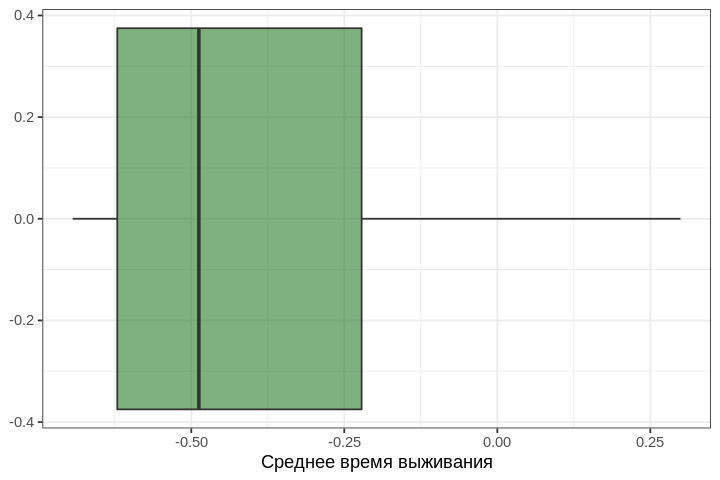

In [ ]:
# Однако для корректного анализа будет лучше обойти долгожителей и привести датафрейм к виду без выбросов
cancer_clear <- cancer[-c(outlier_ind), ]

# Убедимся, что это сработало
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(data = cancer_clear, aes(x = Standardized)) +
      geom_boxplot(fill = 'darkgreen', alpha = 0.5) +
      labs(x = 'Среднее время выживания') +
      theme_bw()

Данные очищены от выбросов, однако стоит учесть еще одну особенность: репрезентативность данных в выборке.

На этом этапе мы приходим к нехорошему результату: 
- оказывается, "долгожители" преимущественно находились в группе болевших раком груди
- теперь наши выборки в случае группировки по органам не являются удачно соотносимыми друг с другом по масштабу

In [ ]:
table(cancer$Organ)
table(cancer_clear$Organ)


  Breast Bronchus    Colon    Ovary  Stomach 
      11       17       17        6       13 


  Breast Bronchus    Colon    Ovary  Stomach 
       5       16       15        4       11 

### **2**
Сравните среднее время выживания пациентов с раком груди и с другими видами рака при помощи t-критерия, сделав поправку на множественное тестирование.

Предварительно пронаблюдаем оставшиеся после очистки данные распределений.
Из любопытного:
- можно заметить, что распределения рака легких и рака желудка фактически индентичны распределению всей выборки по среднему времени выживания

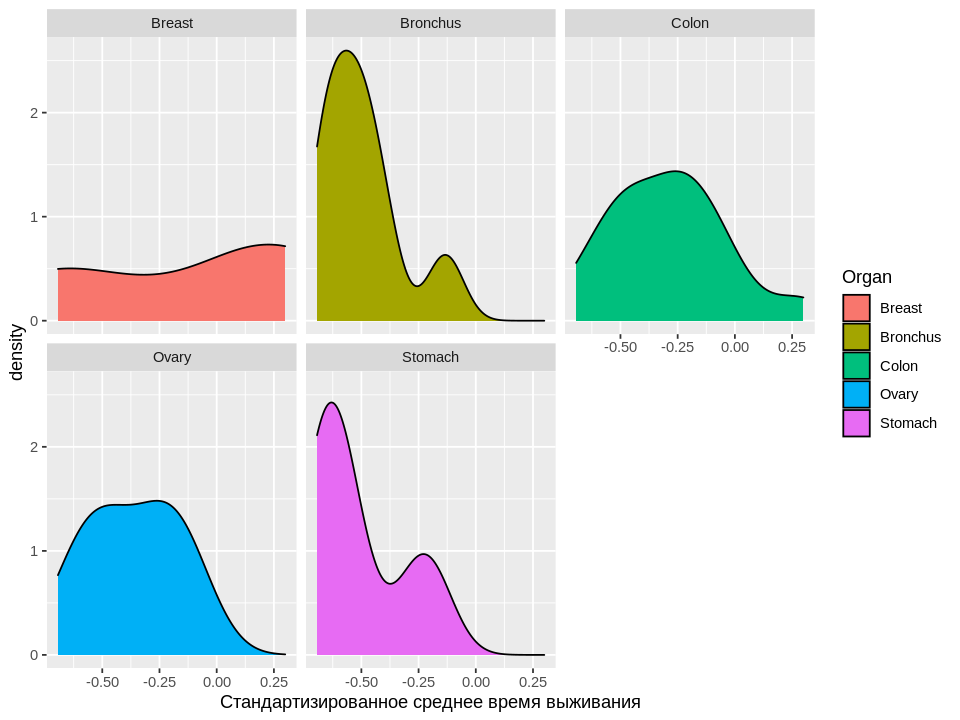

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot() + geom_density(data = cancer_clear, aes(x = Standardized, fill = Organ)) + 
           labs(x = 'Стандартизированное среднее время выживания') +
           facet_wrap(~Organ, nrow = 2)

Двухвыборочный t-тест используется для проверки значимости различий между средними. Нам подойдет t-критерий Уэлча – считаем, что дисперсии могут быть разными.

Т. к. мы наблюдаем за различием данных по раку груди и по остальным видам рака, то у местно будет рассматривать средние (насколько они разнятся).

In [ ]:
info_table <- cancer_clear %>% group_by(Organ) %>% # группируем по органам
  dplyr::summarize(
  .mean = mean(Survival), # выборочное среднее
  .n = n(), # объем выборки
  SE = sd(Survival), # стандартная ошибка
  t_crit = qt(p = 0.995, df = .n - 1), # критич. зн. t для данного n и alpha = 0.05
  err = t_crit * SE, # предел погрешности
  lower = .mean - err, # нижняя граница доверительного интервала
  upper = .mean + err # верхняя граница доверительного интервала
)
info_table

Organ,.mean,.n,SE,t_crit,err,lower,upper
<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Breast,460.2000,5,391.9269,4.604095,1804.4687,-1344.2687,2264.6687
Bronchus,171.1250,16,131.4817,2.946713,387.4390,-216.3140,558.5640
Colon,332.7333,15,194.8840,2.976843,580.1391,-247.4057,912.8724
Ovary,275.5000,4,162.6786,5.840909,950.1911,-674.6911,1225.6911
Stomach,157.2727,11,150.5026,3.169273,476.9836,-319.7109,634.2564


Наша выборка довольно небольшая, поэтому строгая коррекция Бонферрони подойдет.

In [ ]:
p_vals <- cancer_clear$Standardized
sum(p_vals <= 0.05)
p_holm <- p.adjust(p_vals, method = 'holm')
# sum(p_holm <= 0.05)

[1] 47

### **3**
Постройте график с доверительными интервалами (столбчатый или точечный).



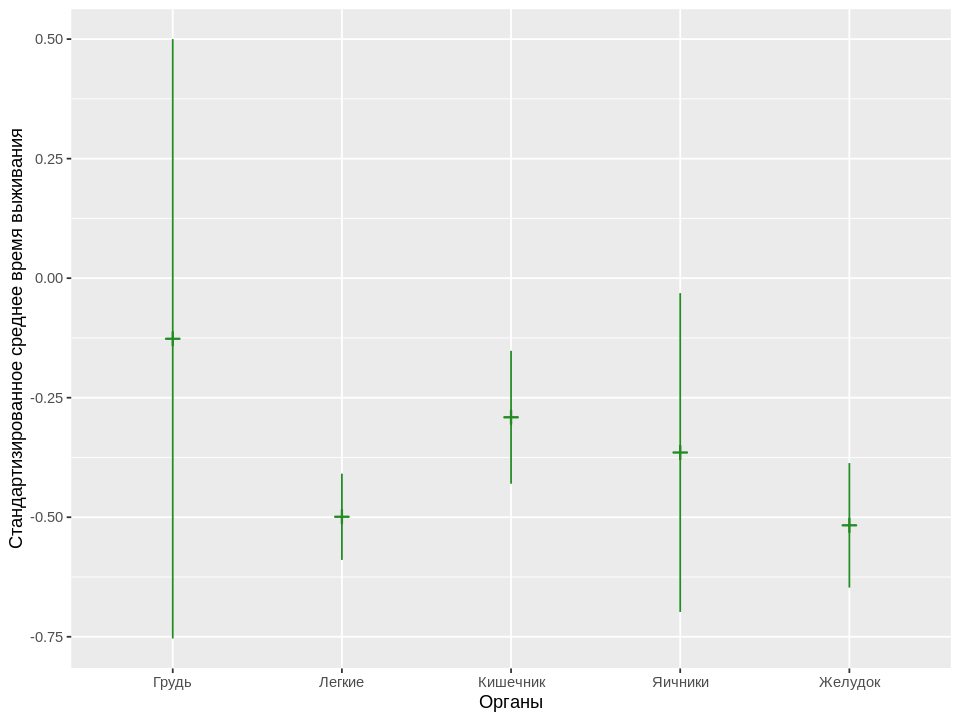

In [ ]:
ggplot(data = cancer_clear, aes(x = Organ, y = Standardized)) +
 stat_summary(colour = 'forestgreen', fun.data = mean_cl_normal, shape = 3) +
 scale_x_discrete(labels = c('Грудь', 'Легкие', 'Кишечник', 'Яичники', 'Желудок')) +
 labs(x = 'Органы', y = 'Стандартизированное среднее время выживания') 

## **Вывод**
Можно сделать два противоположных вывода:
- такое заболевание как рак груди имеет свою некоторую особенность, что позволяет болеющим прожить дольше остальных. Или же выборка оказалась недостаточно репрезентативной;
- препарат аскорбат оказывает наибольшее лечебное воздействие на пациентов с раком груди (то есть мы исключаем, что рак груди сам по себе может иметь свои особенности по продолжительности и что выборка является достаточно репрезентативной, хотя не стоит забывать про размеры исследуемых групп - в идеале они должны быть примерно равны, у нас же сильный разброс еще до удаления выбросов).

## **Список литературы**
[1] RDocumentation. Retrieved 15:47, July 19, 2022, from https://www.rdocumentation.org/

[2] Блог об аналитике, визуализации данных, data science и BI. Retrieved 15:44, July 19, 2022, from https://leftjoin.ru/all/outliers-detection-in-r/

[3] Лекции СПбГУ (в презентациях). Retrieved 15:44, July 19, 2022.

[4] Statology. Retrieved 15:44, July 19, 2022 from https://www.statology.org/

